<a href="https://colab.research.google.com/github/EvenSol/NeqSim-Colab/blob/master/notebooks/process/MultiphaseflowMeasurement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#@title Multiphase flow measurements
#@markdown This document is part of the module ["Introduction to Gas Processing using NeqSim in Colab"](https://colab.research.google.com/github/EvenSol/NeqSim-Colab/blob/master/notebooks/examples_of_NeqSim_in_Colab.ipynb#scrollTo=_eRtkQnHpL70).
%%capture
!pip install neqsim
import neqsim
from neqsim.thermo.thermoTools import *
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
%matplotlib inline

# Multiphase flow measurement
A multiphase flow meter is a device used to measure the individual phase flow rates of constituent phases in a given flow (for example in oil and gas industry) where oil, water and gas mixtures are initially co-mingled together during the oil production processes.

# Litterature

Wikipedia

https://en.wikipedia.org/wiki/Multiphase_flow_meter


HANDBOOK OF MULTIPHASE FLOW METERING:

https://nfogm.no/wp-content/uploads/2014/02/MPFM_Handbook_Revision2_2005_ISBN-82-91341-89-3.pdf

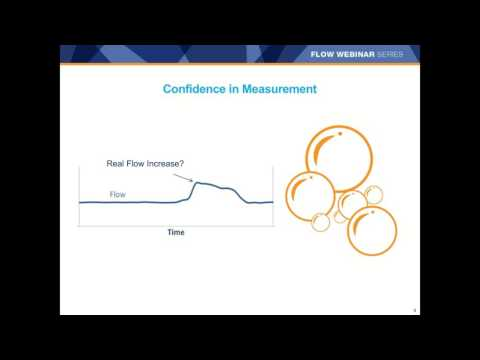

In [2]:
#@title Webinar: Advances in Multiphase Metering for Onshore Measurement in Oil & Gas
#@markdown This video gives an intriduction to Oil & Gas facilities Design
from IPython.display import YouTubeVideo
YouTubeVideo('mcxrjJwidl0', width=600, height=400)

# Calculation of PVT properties for a multiphase flow meter

A typical multi phase flow meter will need calclation of various thermodynamic and physical properties. SUch properties have to be updated s the field is produced. The input to the property calculations are a characterized fluid composition from PVT studies.

The following script demonstrates calculation of PVT properties for a multi phase flow meter using a CHaracterized fluid composition.

                          total          gas          oil                     
           nitrogen  9.62249E-3   9.62249E-3   9.62249E-3      [mole fraction]
                CO2  6.83467E-3   6.83467E-3   6.83467E-3      [mole fraction]
            methane   9.4877E-1    9.4877E-1    9.4877E-1      [mole fraction]
             ethane  2.58299E-2   2.58299E-2   2.58299E-2      [mole fraction]
            propane  1.13911E-3   1.13911E-3   1.13911E-3      [mole fraction]
           i-butane  1.45886E-3   1.45886E-3   1.45886E-3      [mole fraction]
           n-butane  2.39813E-4   2.39813E-4   2.39813E-4      [mole fraction]
          i-pentane  7.79392E-4   7.79392E-4   7.79392E-4      [mole fraction]
          n-pentane  2.19829E-4   2.19829E-4   2.19829E-4      [mole fraction]
              C6_PC  6.59486E-4   6.59486E-4   6.59486E-4      [mole fraction]
              C7_PC  1.10913E-3   1.10913E-3   1.10913E-3      [mole fraction]
              C8_PC  1.06917E-3   1.06917E-3   1.069

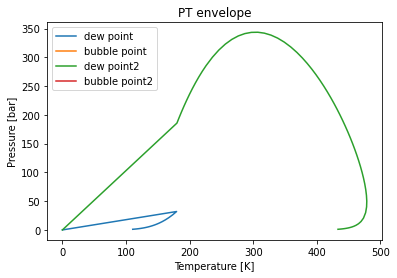

JavaObject id=o5832

In [62]:
names = ['nitrogen','CO2', 'methane', 'ethane', 'propane','i-butane','n-butane','i-pentane','n-pentane']
molefractions = [0.963, 0.684, 94.951, 2.585, 0.114, 0.146, 0.024, 0.078, 0.022]
fluidDefinedComponents = createfluid2(names, molefractions, "mol/sec")

charNames = ["C6", "C7", "C8", "C9", "C10"]
charFlowrate = [0.066, 0.111, 0.107, 0.047, 0.18]
molarMass = [86.18/1000.0, 96.0/1000.0, 107.0/1000.0, 121.0/1000.0, 190.0/1000.0]
density = [664.0e-3, 738.0e-3, 765.0e-3, 781.0e-3, 832.10e-3]
characterizedFluid = addOilFractions(fluidDefinedComponents, charNames,charFlowrate,molarMass,  density);
characterizedFluid.setHeavyTBPfractionAsPlusFraction()
characterizedFluid.getCharacterization().getLumpingModel().setNumberOfPseudoComponents(12);
characterizedFluid.getCharacterization().setLumpingModel("PVTlumpingModel");
characterizedFluid.getCharacterization().characterisePlusFraction();
characterizedFluid.setMixingRule(2)
characterizedFluid.init(0)
characterizedFluid
printFrame(characterizedFluid)
characterizedFluid.setTemperature(273.15+20.6)
characterizedFluid.setPressure(86.8)
TPflash(characterizedFluid)

GORcalc = characterizedFluid.getPhase("gas").getNumberOfMolesInPhase()*8.314*288.15/101325  / (characterizedFluid.getPhase("oil").getVolume("m3"))
print("GOR ", GORcalc)
print('phase envelope for characterized fluid')
phaseenvelope(characterizedFluid, True)

## Generation of properties for multiphase measurements

The following script demonstrates how to generate typical properties for a multiphase flow meter.

In [64]:
import numpy
import numpy as np

pressures = [150.0, 170.0, 180.0, 200.0, 270.0, 320.0, 400.0]
temperatures = [30.0, 40.0, 50.0, 60.0, 80.0]

numP = len(pressures)
numT = len(temperatures)

gasViscosity = numpy.zeros((numP, numT))
oilViscosity = numpy.zeros((numP, numT))
gasDensity = numpy.zeros((numP, numT))
oilDensity = numpy.zeros((numP, numT))
GORcalc  = numpy.zeros((numP, numT))
GORactual = numpy.zeros((numP, numT))
gasViscosity[:] = np.NaN
oilViscosity[:] = np.NaN
gasDensity[:] = np.NaN
oilDensity[:] = np.NaN
GORcalc[:] = np.NaN
GORactual[:] = np.NaN

for i in range(len(temperatures)):
  for j in range(len(pressures)):
    characterizedFluid.setPressure(pressures[j])
    characterizedFluid.setTemperature(temperatures[i]+273.15)
    TPflash(characterizedFluid)
    characterizedFluid.initProperties()
    if(characterizedFluid.hasPhaseType("gas")):
      gasViscosity[j][i]=characterizedFluid.getPhase("gas").getViscosity("cP")
      gasDensity[j][i]=characterizedFluid.getPhase("gas").getDensity("kg/m3")
    if(characterizedFluid.hasPhaseType("oil")):
      oilViscosity[j][i]=characterizedFluid.getPhase("oil").getViscosity("cP")
      oilDensity[j][i]=characterizedFluid.getPhase("oil").getDensity("kg/m3")
    if(characterizedFluid.hasPhaseType("gas") and characterizedFluid.hasPhaseType("oil")):
      GORcalc[j][i] = characterizedFluid.getPhase("gas").getNumberOfMolesInPhase()*8.314*288.15/101325  / (characterizedFluid.getPhase("oil").getVolume("m3"))
      GORactual[j][i] =   (characterizedFluid.getPhase("gas").getVolume("m3"))/ (characterizedFluid.getPhase("oil").getVolume("m3"))

gasDensityDataFrame = pd.DataFrame(gasDensity,index=pressures, columns=temperatures)
oilDensityDataFrame = pd.DataFrame(oilDensity,index=pressures, columns=temperatures)
gasviscosityDataFrame = pd.DataFrame(gasViscosity,index=pressures, columns=temperatures)
oilviscosityDataFrame = pd.DataFrame(oilViscosity,index=pressures, columns=temperatures)
GORcalcFrame = pd.DataFrame(GORcalc,index=pressures, columns=temperatures)
GORactualFrame = pd.DataFrame(GORactual,index=pressures, columns=temperatures)

print("gas density")
print(gasDensityDataFrame.tail())
print("oil density")
print(oilDensityDataFrame.head())
print("gas viscosity")
print(gasviscosityDataFrame.tail())
print("oil viscosity")
print(oilviscosityDataFrame.head())
print("GOR actual")
print(GORactualFrame.head())

gas density
             30.0        40.0        50.0        60.0        80.0
180.0  147.338305  138.962699  131.660332  125.236464  114.437942
200.0  162.645278  153.563175  145.575493  138.505656  126.554824
270.0  207.527074  197.322940  188.038370  179.592502  164.884188
320.0  232.468372  222.239261  212.742943  203.804371  188.271613
400.0  263.029793  253.246972  243.996018  235.273024  219.353614
oil density
             30.0        40.0        50.0        60.0        80.0
150.0  707.889718  712.255191  716.769083  721.432068  731.200914
170.0  706.632222  711.028699  715.672475  720.534254  730.858795
180.0  706.949470  711.296026  715.950380  720.867486  731.421311
200.0  709.523103  713.638788  718.205086  723.150916  734.090956
270.0  739.053481  741.132778  744.198472  747.980170  756.457872
gas viscosity
           30.0      40.0      50.0      60.0      80.0
180.0  0.018397  0.018133  0.017964  0.017866  0.017822
200.0  0.019587  0.019213  0.018948  0.018769  0.018595
27